In [6]:
# from PIL import Image
# import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib.colors import ListedColormap
import cv2

## Turn the .tiff file image data into handeble .h5 data file. 

In [13]:
# # Import .tif file
# im = Image.open("/home/rutian/Videos/cut1.tif")

# tif_path = "/home/rutian/Videos/cut1.tif"

# with tiff.TiffFile(tif_path) as tif:
#     image_stack = tif.asarray()

# # The data from two channels. Use type uint8 to sparse space. 
# channel_green = image_stack[:, 0, :, :] # The green channel with aggregates.
# all_green_frames = np.array(channel_green)

# channel_red = image_stack[:, 1, :, :] # The channel with red beads.
# all_red_frames = np.array(channel_red)

# # Store the image information into .h5 file. With compression algorithm "gzip" and compression factor 5 (max 9). 
# h5_file_path = "cut1.h5"
# with h5py.File(h5_file_path, "w") as h5f:
#     h5f.create_dataset("green", data = all_green_frames, compression="gzip", compression_opts=5)
#     h5f.create_dataset("red", data = all_red_frames, compression="gzip", compression_opts=5)

## Import .h5 data containing aggregate and red beads channels.

In [2]:
# open h5 files.

h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/subregion_cut1(2).h5"
with h5py.File(h5_file_path, "r") as h5f:
    green_channel = h5f["green"][:]
    red_channel = h5f["red"][:]

In [3]:
print("green channel shape:", green_channel.shape)
print("red beads shape:", red_channel.shape)

green channel shape: (375, 900, 800)
red beads shape: (375, 900, 800)


## Mask the red beads 

In [5]:
# red_image = red_channel[100]
# red_threshold = np.median(red_image)
# red_mask = np.where(red_image > red_threshold, 1, 0)

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title("Original Red Beads")
# plt.imshow(red_image)

# plt.subplot(1, 2, 2)
# plt.title("Red Beads Mask")
# plt.imshow(red_mask, cmap= ListedColormap(["white", "red"]))
# plt.show()

In [13]:
# def mask_red_channel(red_beads_channel):
    
#     original_mask = []
    
#     for i in range(red_beads_channel.shape[0]):
#         red_image = red_channel[i]
#         red_threshold = np.median(red_image)
#         red_mask = np.where(red_image > red_threshold, 1, 0)
#         original_mask.append(red_mask)

#     return np.array(original_mask)

## Stroing the red beads mask for PIV analysis. 

In [20]:
# h5_file_path = "red_beads_cut1.h5"
# with h5py.File(h5_file_path, "w") as h5f:
#      h5f.create_dataset("original_red_beads_mask", data = original_red_beads)

## Apply masks to find the region covered by skin and cut out the region for red beads.

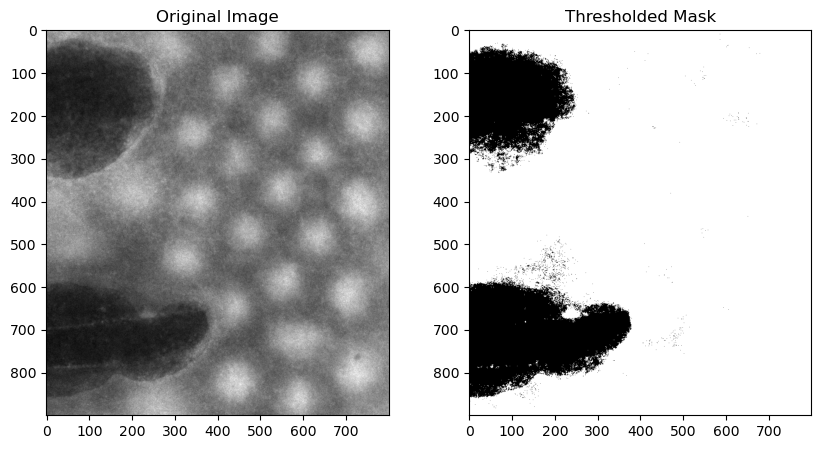

In [14]:
image = green_channel[100]
threshold = np.median(image) - 60

# mask = np.where(image > threshold, 255, 1) # If using filling holes function. 
mask = np.where(image > threshold, 1, 0) # Above to 1 (white) and below to 0 (black).

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Thresholded Mask")
plt.imshow(mask, cmap='gray')
plt.show()

## Want to fill the hole of images... (Necessary?)

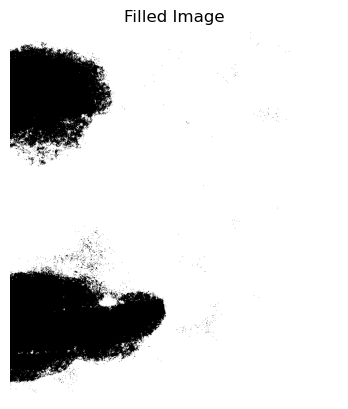

In [5]:
import cv2
import numpy as np

image = mask 
# Convert blank (e.g., 0) pixels to holes for filling
#_, binary = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)

if image.dtype != np.uint8:
    image = image.astype(np.uint8)

# Apply threshold
_, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)

# Ensure the thresholded image is uint8 (this should already be correct)
binary = binary.astype(np.uint8)

# Invert the binary image
inverted_binary = cv2.bitwise_not(binary)

# Ensure the inverted binary image is also uint8
inverted_binary = inverted_binary.astype(np.uint8)

# Find contours of the holes
contours, _ = cv2.findContours(inverted_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Fill the holes
filled_image = image.copy()
cv2.drawContours(filled_image, contours, -1, (255,), thickness=cv2.FILLED)

# Save or display the result
plt.imshow(filled_image, cmap='gray')
plt.title('Filled Image')
plt.axis('off')  # Hide the axis
plt.show()

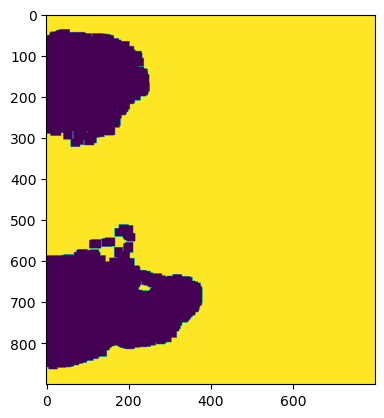

In [12]:
_, binary = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
binary = binary.astype(np.uint8)
kernel = np.ones((20, 20), np.uint8)
filled_image = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
plt.imshow(filled_image)

## Overlap the masks from green channel and red channel to cut the red beads region based on mask from green channel.

In [19]:
def overlap_mask(green_channel, red_channel, t):
    # Red channel with red beads. Green channel of cut skin. 
    # The mask from green channel define the covered regions. 
    # The mask from red channel is for piv analysis on beads.
    # Overlap the masks to ensure that the piv analysis of red beads is only on the region covered by skin. 
    green_image = green_channel[t]
    red_image = red_channel[t]

    green_threshold = np.median(image) - 60
    # red_threshold = np.median(red_image)

    green_mask = np.where(green_image > green_threshold, 1, 0) # Above threshold 0, under threshold (background) nan. 
    # red_mask = np.where(red_image > red_threshold, 1, 0) # If also making binaration/segmentation of red beads.

    return green_mask * red_image # (green_mask + red_mask)

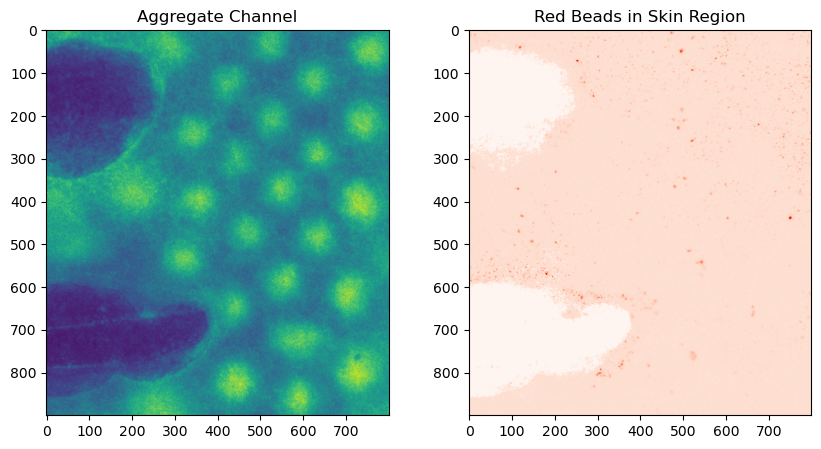

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Aggregate Channel")
plt.imshow(green_channel[100])
plt.subplot(1, 2, 2)
plt.title("Red Beads in Skin Region")
plt.imshow(overlap_mask(green_channel, red_channel, 100), cmap= "Reds")
plt.show()

In [26]:
def all_frame_overlap_mask(green_channel, red_channel):
    # Generate overlap masks for all frames. 
    total_frame = green_channel.shape[0]
    cuts = []
    for t in range(total_frame): 
        cuts.append(overlap_mask(green_channel, red_channel, t))
    return np.array(cuts)

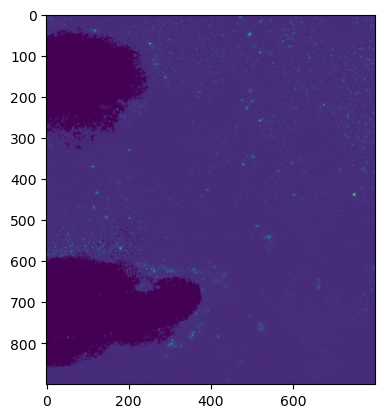

In [29]:
cutted_red_beads = all_frame_overlap_mask(green_channel, red_channel)

## Store the cutted red beads images. 

In [31]:
h5_file_path = "cutted_red_beads_cut1.h5"
with h5py.File(h5_file_path, "w") as h5f:
    h5f.create_dataset("cutted_red_beads", data = cutted_red_beads)

## Store the masked red beads for all frames

In [111]:
all_mask = all_frame_overlap_mask(green_channel, red_channel)

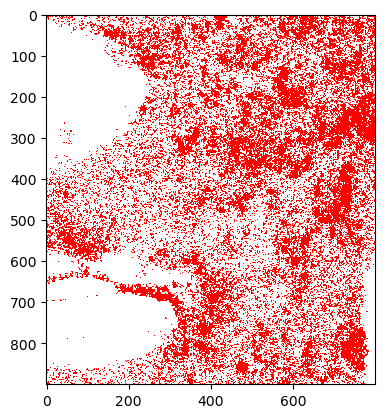

In [112]:
plt.imshow(all_mask[300], cmap= ListedColormap(["white", "red"]))

In [88]:
h5_file_path = "mask_red_beads_cut1.h5"
with h5py.File(h5_file_path, "w") as h5f:
    h5f.create_dataset("masked_red_beads", data = all_mask)